In [1]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [2]:

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
path='/content/drive/My Drive/dataset.xlsx'
df = pd.read_excel(path)

df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Bug-ID,Project,Classification,Summary,Link,Enviroment,Unnamed: 6
0,XALANC-11,XalanC,Add issue,Documentation comment for getVariable/getParam...,https://issues.apache.org/jira/browse/XALANC-1...,APACHE,123.0
1,SVN-491,Subversion,Add issue,svn status' needs better error reporting,https://issues.apache.org/jira/browse/SVN-491?...,APACHE,NaN
2,FOP-57,FOP,Add issue,Multolingual support in converting xml - pdf,https://issues.apache.org/jira/browse/FOP-57?j...,APACHE,NaN
3,VELOCITY-31,Velocity,Add issue,Velocity should provide an interface for expli...,https://issues.apache.org/jira/browse/VELOCITY...,APACHE,NaN
4,SVN-2196,Subversion,Add issue,Translate svn-ref.tex to French,https://issues.apache.org/jira/browse/SVN-2196...,APACHE,NaN
...,...,...,...,...,...,...,...
1275,483857,MailNews Core,Test Code-related issue,JavaScript Debug assertions in gloda mime tests,https://bugzilla.mozilla.org/show_bug.cgi?id=4...,MOZILLA,NaN
1276,550980,MailNews Core,Test Code-related issue,nsMsgDBFolder.cpp:180: error: cannot convert ‘...,https://bugzilla.mozilla.org/show_bug.cgi?id=5...,MOZILLA,NaN
1277,792804,MailNews Core,Test Code-related issue,Test failure: mailnews/news/test/unit/test_bug...,https://bugzilla.mozilla.org/show_bug.cgi?id=7...,MOZILLA,NaN
1278,45882,SeaMonkey,Test Code-related issue,Test bug,45882,MOZILLA,NaN


In [4]:
# Import label encoder
from sklearn import preprocessing
 

label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
df['Classification']= label_encoder.fit_transform(df['Classification'])
print(df.Classification.unique())


[ 0  1  2  3  4  5  6  7 15 16  8  9 10 11 12 13 14]


In [5]:
# Create sentence and label lists
summaries = df.Summary.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
summaries = ["[CLS] " + sentence + " [SEP]" for sentence in summaries]
classifications = df.Classification.values

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in summaries]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'documentation', 'comment', 'for', 'get', '##var', '##iable', '/', 'get', '##para', '##m', '##var', '##iable', 'incorrect', '[SEP]']


In [7]:
MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [8]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, classifications, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [9]:
train_labels

array([12, 10,  1, ...,  1,  4, 14])

In [10]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [11]:
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [12]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=17)

In [13]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]

In [14]:
optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

t_total value of -1 results in schedule not being applied


In [15]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [16]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs 
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 2.1359447737534842


Epoch:  50%|█████     | 1/2 [27:33<27:33, 1653.89s/it]

Validation Accuracy: 0.3515625
Train loss: 1.6810360583994124


Epoch: 100%|██████████| 2/2 [55:18<00:00, 1659.16s/it]

Validation Accuracy: 0.4296875


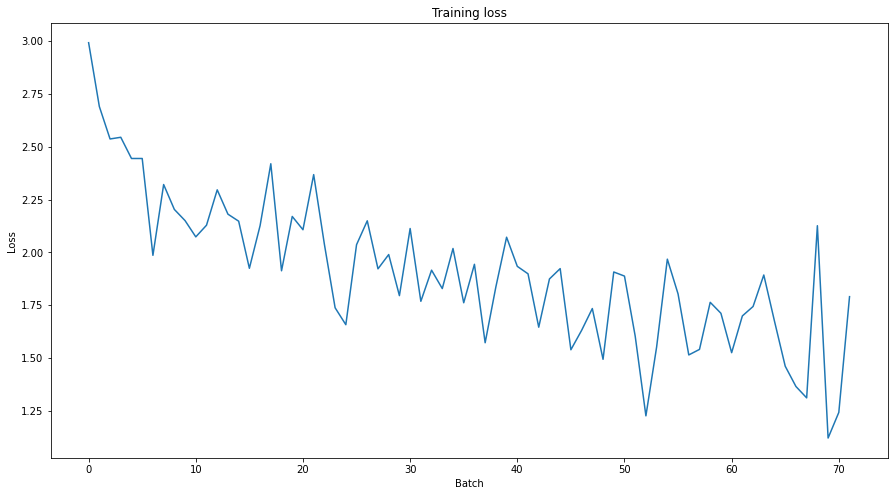

In [20]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()